## Exploring Noise with Dynamic Circuits on Amazon Braket with IQM

One of the key applications of dynamic circuits is related to harnessing and correcting errors or noise in quantum circuits. Access to mid-circuit measurements allows for detection, and feedforward operations allow us to make adjustments or corrections to the target state. It is also important to describe the error rates associated with the extra measurement procedures occuring. 

In this notebook we look at examples of entanglement stabilization as well as readout error mitigation for an active qubit reset. 


### Notebook Setup

Before we dive into our examples, let's (again) handle our imports. For simplicity, we will work here with standard Clifford gates, Pauli rotations, and `cc_x` or `cc_z` primitives. The `cc_x` gate (and by a simple rotation `cc_z`) applies a X gate conditionally on a particular measurement configuration.

In the local simulator, we use a composition of a partial trace and initialization procedure, which are both valid quantum channels and thus can be implemented through their Kraus operators ($\mathcal{E}[\rho]=  \sum K_i \rho K_i^\dagger$):

$$K_0= |0\rangle \langle 0 | \otimes I $$

$$ K_1 = |0 \rangle \langle 1 | \otimes X $$

Notes on `iqm_config.py` and `local_config.py`:
- `cc_x` and `cc_z` are *user defined* gate types. Use the `reset` keyword to specify an active reset. 
- These gates assume that `measure_ff` and any `cc_prx` are implemented at the same layer and time, and can be concatenated as `cc_x`.
- Importing `iqm_config.py` transpiles Clifford circuits to native IQM gates.
- For actual implementations, see the respective `iqm_config.py` or `local_config.py` files.

In [1]:
from math import pi

import matplotlib.pyplot as plt

from braket.circuits import Circuit
from braket.experimental_capabilities import EnableExperimentalCapability
from braket.tracking import Tracker


In [ ]:
use_qpu = True
kw = {}

if use_qpu: 
    import iqm_config
    qd = iqm_config.qd
    kw["tags"] = iqm_config.tags
else:
    import local_config
    qd = local_config.qd

track = Tracker().start()

def calc_z_exp(counts : dict, qubits : list) -> float:
    """ calculate z_expectations from shots on particular qubits """
    val = 0
    for k,v in counts.items():
        val+= v*(-1)**len([k[i] for i in qubits if k[i]=="1"])
    return val/sum(list(counts.values()))

### Stabilizing Bell States 

Next, we look at a simple stabilization experiment utilizng Bell states and dynamic circuits. Theoretically this can be described as follows. 

Take the first Bell state:
$$|\psi \rangle =  \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle) $$ 

We can consider parity and (real) phase errors. If a bit flip error occurs for instance on either qubit, then we transition to the state:

$$X_1|\psi \rangle = X_2|\psi\rangle = \frac{1}{\sqrt{2}}(|01\rangle + |10\rangle)$$ 

Importantly, the errors here are symmetric with respect to either bit flip. Thus a $X$ gate on either 1 or 2 is sufficient to correct it. If we consider phase errors, then we also have that:

$$Z_1|\psi\rangle = Z_2 | \psi\rangle = \frac{1}{\sqrt{2}}(|00\rangle - |11\rangle)$$ 

As above, both of these errors can be mitigated using a single $Z$ application on either qubit. The state is actually protected against dual bit flips, as well as dual phase errors. For a combined error bit and phase error we see: 
$$Z_1 X_2|\psi\rangle = \frac{1}{\sqrt{2}} (|01\rangle - |10\rangle) = Z_2 X_1 |\psi\rangle $$ 

If the errors occur on the same qubit:
$$ Z_1 X_1 |\psi\rangle = - X_1 Z_1 |\psi\rangle = -\frac{1}{\sqrt{2}}(|10\rangle - |01\rangle) $$ 

then we can still similarly correct the qubit. To verify, we can make a Bell state measurement, which yields the expectation values of $X_1 X_2$, $Z_1 Z_2$ and $-Y_1 Y_2$ and which the chosen Bell state is a eigenvector with eigenvalues +1. The following example allows us to manually insert errors, apply the correction, and see the resulting expectations. 

#### Laying this out to IQM Garnet

To realize this on the IQM Garnet architeture is not straightforward, as we need to find support for 5 out of 6 of the available CNOTs in a 4-qubit layout, say on qubits 7, 6, 11, and 12. 

<img src="images/iqm_groups.png" alt="drawing" width="200"/>

The most straigthforward way is (1) create a Bell state on qubits 7 and 6, (2) swap 6 with 11, and then use 6 and 12 for parity and bit flip checks, respectively. Alternatively, we can use a single ancilla, to perform a parity check, reset, and then perform a bit-flip check. Step (2) can also be performed with a Z- or X-teleportation. 
- *Note, we do have to be careful with qubit selection, but here there is no conflict as we use the same `cc_x` on the parity check and the X-teleportation.*

However, we can also use the method in the work by [Andersen et al.](https://www.nature.com/articles/s41534-019-0185-4), where the initial mid-circuit measurement helps to create the entangled pair state. That is, we put qubits 0 and 2 in the $|+x>$ state, apply CNOTs to a register, and then apply a classically condition $X$ on either register. This gives us the appropriate Bell State. 

In [ ]:
qreg = [7,6,11,12]

with EnableExperimentalCapability():
    circ = Circuit()
    circ.h(qreg[0])
    circ.h(qreg[2])
    circ.h(qreg[1])
    circ.cz(qreg[0],qreg[1])
    circ.cz(qreg[2],qreg[1])
    circ.h(qreg[1])
    circ.cc_x([qreg[1],qreg[2]])
    
    # apply phase and parity errors 
    circ.rz(qreg[0], pi)
    circ.rx(qreg[2], pi)

    circ.cnot(qreg[0],qreg[1]) 
    circ.cnot(qreg[2],qreg[1])

    circ.h(qreg[3])
    circ.cnot(qreg[3],qreg[0])
    circ.cnot(qreg[3],qreg[2])
    circ.h(qreg[3])

    circ.cc_x([qreg[1],qreg[2]]) 
    circ.cc_z([qreg[3],qreg[0]]) 

    # bell state measurement
    circ.cnot(qreg[2], qreg[1])
    circ.cnot(qreg[1], qreg[2])
    circ.cnot(qreg[0],qreg[1])
    circ.h(qreg[0])

    if use_qpu: 
        circ = Circuit().add_verbatim_box(circ)
    circ.measure([qreg[0],qreg[2]])
    res = qd.run(circ, shots=500, **kw).result()
    print(circ)
    exp = [calc_z_exp(res.measurement_counts, qi) for qi in [[0],[1],[0,1]]]
    print(res.measurement_counts)
    print('\nExpectations:')
    print(f'+<XX>: {exp[0]}')
    print(f'+<ZZ>: {exp[1]}')
    print(f'-<YY>: {exp[2]}')



T   : │        0        │         1         │       2        │  3  │          4           │         5          │       6        │    7    │         8          │         9         │       10       │ 11  │        12         │         13         │        14         │       15        │            16            │        17         │         18         │         19         │         20         │         21         │         22         │         23         │        24         │         25         │ 26  │        27         │         28         │ 29  │        30         │         31         │      32       │ 33  │
                         ┌─────────────────┐ ┌──────────────┐ ┌───┐ ┌───┐                  ┌─────────────────┐  ┌──────────────┐ ┌───────┐ ┌──────────────────┐ ┌─────────────────┐ ┌──────────────┐ ┌───┐  ┌───────────────┐  ┌──────────────────┐ ┌─────────────────┐ ┌──────────────┐  ┌───┐                       ┌───────────────┐  ┌──────────────────┐      ┌───────┐       ┌───────────────

In lieu of detailed optimization (i.e. moving the parity and phase to the same detection qubit, choosing qubits, etc.), we can simplify this to just look at a simulated parity error. In this case, we first consider apply a bit error, and then perform a simply bitflip detection and correct, and output to the computational basis states.  

In [ ]:
qreg = [14,15,19]

correction = [False, True]
res_correct = []

with EnableExperimentalCapability():
    for correct in correction:
        circ = Circuit()
        circ.h(qreg[0])
        circ.h(qreg[2])
        circ.h(qreg[1])
        circ.cz(qreg[0],qreg[1])
        circ.cz(qreg[2],qreg[1])
        circ.h(qreg[1])
        circ.cc_x([qreg[1],qreg[2]])
        # add error
        circ.x(qreg[0])

        if correct:
            circ.h(qreg[1])
            circ.cz(qreg[0],qreg[1])
            circ.cz(qreg[2],qreg[1])
            circ.h(qreg[1])
            circ.cc_x([qreg[1], qreg[2]])

        if use_qpu: 
            circ = Circuit().add_verbatim_box(circ)
        circ.measure([qreg[0], qreg[2]])
        res_correct.append(qd.run(circ, shots=500, **kw).result())

Uncorrected: 
Counter({'01': 223, '10': 216, '00': 34, '11': 27})
Corrected: 
Counter({'00': 214, '11': 168, '01': 81, '10': 37})


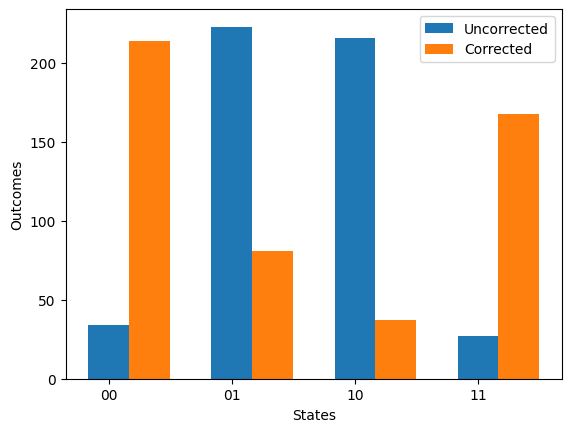

In [30]:
uncorr = res_correct[0].measurement_counts
corr   = res_correct[1].measurement_counts

keys = ["00","01","10","11"]
print('Uncorrected: ')
print(uncorr)
print('Corrected: ')
print(corr)

width = 0.33
plt.bar(range(4), [uncorr.get(k,0) for k in keys],width=width,label="Uncorrected")
plt.bar([i+width for i in range(4)], [corr.get(k,0) for k in keys ],width=width,label="Corrected")
plt.xticks([0,1,2,3],keys)
plt.xlabel("States")
plt.ylabel("Outcomes")
plt.legend()
plt.show()

### Error Mitigation in Mid-Circuit Measurements

Noise in mid-circuit measurements unfortunately represent a large source of errors, generically due to the increased error rates in performing quantum measurements. Unitary circuits in some cases can be preferable due to the higher associated fidelities. 

Below we explore a simplified readout error mitigation model for active bit-flip protection, using a single data and ancilla qubit (see [here](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.6.010307) for more details).  First we note that output states $00$ and $01$ represent 'correct' input states, whereas $10$ and $11$ represent incorrect states. These can happen for a variety of reasons, but we define the probability of successful reset as $p_{00}$ + $p_{01}$, and an unsuccessful reset as $p_{10}$ + $p_{11}$. 

To probabilistically correct this, we insert a $X$ gate on the data qubit with probability $p$. We can process this by assigning a negative weight to incorrect outcomes and subtracting from the ideal outcomes, or just tallying the total number of $0$ states. To achieve a total success number of $N$, we need an additional sampling factor, $\gamma = 1/(1-2p)$. 

- *To see how this resolves, the $I$ circuit (which we select with probability $N \gamma (1-p)$) has $N \gamma (1-p)^2$ successful outcomes. The $X$ circuit has $N \gamma p^2$ successful outcomes, which combined gives $N$ successful outcomes.* 

In [ ]:
p_depol = 0.01
N_s = 1000
qreg = [1,2]

with EnableExperimentalCapability():
    qc = Circuit()
    qc.h(qreg[0])
    qc.cnot(qreg[0],qreg[1])
    if not use_qpu:
        qc.depolarizing([qreg[0],qreg[1]],p_depol)
    qc.cc_x([qreg[1], qreg[0]])
    if not use_qpu:
        qc.depolarizing([qreg[0],qreg[1]],p_depol)
    
    if use_qpu: 
        qc = Circuit().add_verbatim_box(qc)

    result = qd.run(qc, shots=N_s, **kw).result()

    print(qc)

T  : │        0        │         1         │       2        │  3  │          4          │         5          │    6     │          7          │       8       │
                        ┌─────────────────┐ ┌──────────────┐       ┌───────────────────┐                                                                       
q1 : ───StartVerbatim───┤ PRx(1.57, 1.57) ├─┤ PRx(3.14, 0) ├───●───┤ 13→CCPRx(3.14, 0) ├─────────────────────────────────────────────────────────EndVerbatim───
              ║         └─────────────────┘ └──────────────┘   │   └───────────────────┘                                                              ║        
              ║         ┌─────────────────┐ ┌──────────────┐ ┌─┴─┐   ┌───────────────┐   ┌──────────────────┐ ┌────────┐ ┌───────────────────┐        ║        
q2 : ─────────╨─────────┤ PRx(1.57, 1.57) ├─┤ PRx(3.14, 0) ├─┤ Z ├───┤ PRx(-3.14, 0) ├───┤ PRx(-1.57, 1.57) ├─┤ MFF→13 ├─┤ 13→CCPRx(3.14, 0) ├────────╨────────
                        └───────────────

From this result we can model our effective error rate. 

In [26]:
counts = result.measurement_counts
p = (counts['10'] + counts['11'])/sum(counts.values())
success = counts['00']+ counts['01']
scaling = 1/(1-2*p)
print(f'Shots with  reset: {counts}')
print(f'Successful shots: {success}')
print(f'Probability of success p: {1-p}')
print(f'Scaling factor: {scaling}')

Shots with  reset: Counter({'00': 845, '10': 75, '01': 62, '11': 18})
Successful shots: 907
Probability of success p: 0.907
Scaling factor: 1.2285012285012284


To correct this, we take $N$ shots, multiply by our scale factor $\gamma$, $N' = N*\gamma$, and allocate $N'p$ shots to a bit flip and $N'(1-p)$ to the identity case. 

In [ ]:
from numpy.random import multinomial

Np = round(N_s*scaling)
N_i, N_x = multinomial(Np,[1-p,p])
N_i, N_x = int(N_i), max(1,int(N_x))
qreg = [1,2]

with EnableExperimentalCapability():
    qc = Circuit()
    qc.h(qreg[0])
    qc.cnot(qreg[0],qreg[1])
    if not use_qpu:
        qc.depolarizing([qreg[0],qreg[1]],p_depol)
    qc.cc_x([qreg[1], qreg[0]])
    if not use_qpu:
        qc.depolarizing([qreg[0],qreg[1]],p_depol)
    qc_i = qc.copy()
    qc_x = qc.copy()
    qc_x.x(qreg[0])

    if use_qpu: 
        qc_i = Circuit().add_verbatim_box(qc_i)
        qc_x = Circuit().add_verbatim_box(qc_x)

    res_i = qd.run(qc_i, shots=N_i, **kw).result()
    res_x = qd.run(qc_x, shots=N_x, **kw).result()

And we perform our post processing...

In [ ]:
counts_i = res_i.measurement_counts
counts_x = res_x.measurement_counts
success = counts_i['00'] + counts_i['01'] - counts_x['00'] - counts_x['01']

psuedo_p = success/N_s

print(f'Average success per mitigated shot: {psuedo_p}')

Average success per mitigated shot: 1.018


And we have successfully mitigated our active bit flip procedure. In practice this can be substantially more complicated, requiring techniques seen in some of the references below. 

### Checking in on costs

You can try these out on IQM Garnet for the expected value listed in the next block. 

In [ ]:
if use_qpu:
    print("Quantum Task Summary")
    print(track.quantum_tasks_statistics())
    print(
        "Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).",
    )
    print(
        f"Estimated cost to run this example: {track.qpu_tasks_cost() + track.simulator_tasks_cost():.3f} USD",
    )

### Conclusions

In this notebook we looked at examples of how dynamic circuits can help correct or mitigate noise in quantum systems. In particular, the Bell state stabilization represents a fundamental tools for building more advanced protocols. While fault tolerant error correction codes are beyond the scope presented here, dynamic circuits provide building block for these appliciations. Readout mitigation also represents a critical tool for enabling more reliable results for near-term devices, particularly when dominant error sources from mid-circuit measurements may be difficult to characterize. 


### References: 
1. Andersen, Remm, Lazar et al. *Entanglement stabilization using ancilla-based parity detection and real-time feedback in superconducting circuits* (2019) [npj Quant. Info. 5, 69](https://www.nature.com/articles/s41534-019-0185-4)
2. Hashim, Carignan-Dugas, Chen et al. Quasiprobabilistic Readout Correction of Midcircuit Measurements for Adaptive Feedback via Measurement Randomized Compiling (2025) [PRX Quantum 6, 010207](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.6.010307) 
